# Analysing Historical Football Data

For this analysis, I am using data from the Open Football project, which provides open public domain football data in CSV format (https://footballcsv.github.io/) for download. The Open Football project provides data from many leagues across the world, however, I will be focusing on the top division of English football for which data is provided between most of the years between the inaugural 1888-89 season to the just finished 2019-2020 season.

### Contents

This project is broken up into sections. Each demonstrates a part of the process of data analysis from taking the data in its raw form and preparing it for analysis (part A), exploring the data through EDA (part B), and finally creating polished visualisations which tell a story with the data (part C).

A. Preparing the dataset (data cleaning)
- Creating the desired dataset(s) - writing functions which create pandas dataframes for any variation of English top division seasons.
- Cleaning and enhancing the dataset - dealing with missing data and enhancing the dataset by adding additional information inferred from the existing data.
- Filtering the data - adding functions which filter the data by team results, matchups, and adding team-specific statistics.
- Managing the data - adding all of the functions as methods to a class to quickly and conveniently create these filtered subsets of the data and populate a dataframe for exploratory data analysis.

B. Exploratory Data Analysis

Historical trends (1888-2020)

C. Vizualisations


# A. Preparing the dataset

There are a number of wrinkles with the data that will require some adjustments before we can begin the analysis proper.

## Creating the desired dataset(s)
Firstly, the download provides CSV files for each available season in separate folders - by decade, season, and then finally CSV files for each division. 

For example, the path to the CSV file containing results from the 2019-20 season of the English Premier League (the top division of English football) is:

> */path to folder/England-master/2010s/2019-20/eng.1.csv*

For flexibility, we want to be able to access any individual season for which there is data, as well as the ability to merge them into a single dataset.

For this purpose, we have a function that populates a dictionary with the correct paths for each CSV:

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
import matplotlib.patheffects as path_effects
import seaborn as sns

from io import BytesIO

#This creates a dictionary with paths to each season's CSV file. You can modify the number of seasons by decade.
def seasons_dictionary(starting_decade, ending_decade):
    eng = 'path_to\Football_python\england-master'
    #Populate a dictionary with a string like '2010s' as the key and a string like '2010-11' as the value
    seasons = {}
    for i in range(int(abs((starting_decade - ending_decade)/10)) + 1):
        decade = starting_decade
        decade_string = str(decade) + 's'
        list_of_seasons = []
        for i in range(10):
            season = str(decade + i) + '-' + str(decade + i + 1)[2:4]
            list_of_seasons.append(season)
            seasons[decade_string] = list_of_seasons
        starting_decade += 10
    #Using the dictionary above, populate another dictionary with a string like 'df_eng_2010-11" as the key, and the path to the file for the 2010-11 season as the value.
    df_dictionary = {}
    for decade in seasons:
        for season in seasons[decade]:
            path = eng + '\\' + decade + '\\' + season + '\eng.1.csv'
            df_name = 'df_eng_' + season
            df_dictionary[df_name] = path
    return df_dictionary

#To return the paths for every season in the 2010s:
seasons_dictionary(2010, 2010)

{'df_eng_2010-11': 'path_to\\Football_python\\england-master\\2010s\\2010-11\\eng.1.csv',
 'df_eng_2011-12': 'path_to\\Football_python\\england-master\\2010s\\2011-12\\eng.1.csv',
 'df_eng_2012-13': 'path_to\\Football_python\\england-master\\2010s\\2012-13\\eng.1.csv',
 'df_eng_2013-14': 'path_to\\Football_python\\england-master\\2010s\\2013-14\\eng.1.csv',
 'df_eng_2014-15': 'path_to\\Football_python\\england-master\\2010s\\2014-15\\eng.1.csv',
 'df_eng_2015-16': 'path_to\\Football_python\\england-master\\2010s\\2015-16\\eng.1.csv',
 'df_eng_2016-17': 'path_to\\Football_python\\england-master\\2010s\\2016-17\\eng.1.csv',
 'df_eng_2017-18': 'path_to\\Football_python\\england-master\\2010s\\2017-18\\eng.1.csv',
 'df_eng_2018-19': 'path_to\\Football_python\\england-master\\2010s\\2018-19\\eng.1.csv',
 'df_eng_2019-20': 'path_to\\Football_python\\england-master\\2010s\\2019-20\\eng.1.csv'}

Using the dictionary produced by this function, we can then specify any individual season (CSV file) to read in to a pandas dataframe.

In [535]:
#Creates a data frame from the CSV file of the specified season
def create_df(season):
    all_seasons = seasons_dictionary(1880, 2010)
    all_seasons['df_eng_' + season]
    df = pd.read_csv(all_seasons['df_eng_' + season])
    return df

#for the sake of readability, this function will display a certain amount of rows in the df
def display_n(df,n): 
    with pd.option_context('display.max_rows',n*2):
        display(df)

#For example, here's a snapshot of the 2014-15 Premier League season:
EPL_14_15 = create_df('2014-15')
display_n(EPL_14_15, 2)

,Round,Date,Team 1,FT,HT,Team 2
0,?,(Sat) 16 Aug 2014 (W33),Arsenal FC (1),2-1,1-1,Crystal Palace FC (1)
1,?,(Sat) 16 Aug 2014 (W33),Leicester City FC (1),2-2,1-2,Everton FC (1)
...,...,...,...,...,...,...
378,?,(Sun) 24 May 2015 (W21),Newcastle United FC (38),2-0,0-0,West Ham United FC (38)
379,?,(Sun) 24 May 2015 (W21),Stoke City FC (38),6-1,5-0,Liverpool FC (38)


We also want to be able to look at more than a single season, even though the data is contained in separate CSV files. Building on the seasons_dictionary function again, we can read in and merge the CSV files for multiple seasons. To delineate the data for each season, we will also add a column for each season's dataframe before we merge them together.  

Note that we could easily do the same for the different leagues as well, we would just need to accomodate another parameter which specifies the file name - e.g., a parameter of 1 could select the 'eng.1.csv' filename in the generated path, 2 could select 'eng.2.csv' etc. For the purposes of this analysis we'll be sticking to the first division ('eng.1.csv') files - with over a century of fixtures to pore over, that will be plenty.

Note that not every year has data. There were interruptions to professional football, most notably during the years of the World Wars. The function has accommodated for this with error handling.

Below, we use the merge_df function below to create a data frame containing *all* the available data for top flight English football, from the 1888-89 seasons to the 2019-20 season.

In [536]:
#Finally, this function reads in any number of season datasets as specified in the argument, and merges them into a single dataframe
def merge_df(start_season, end_season):
    df_dictionary = seasons_dictionary(1880, 2010)
    df_list = []
    seasons_list = []
    #Identify the index of the starting season and ending season specified
    start_index = list(df_dictionary.keys()).index('df_eng_' + start_season)
    end_index = (list(df_dictionary.keys()).index('df_eng_' + end_season)) + 1
    #Loop through these indices to populate the seasons_list with the desired keys for seasons_dictionary
    for i in range(start_index, end_index):
        season_key = list(df_dictionary.keys())[i]
        seasons_list.append(season_key)
    #Use the keys in seasons_list to fetch the paths to each season, and reading them in to a list of dfs in df_list
    for i in df_dictionary:
        if i in seasons_list:
            try:
                df = pd.read_csv(df_dictionary[i], index_col=None, header=0)
    #While we're at it, use regex to isolate the season for each CSV file, and add it as a column to the dataframe before appending it to df_list
                season = re.findall(r'\d\d\d\d-\d\d', i)[0]
                df['Season'] = season
                df_list.append(df)
            except FileNotFoundError: #This exception accommodates the fact that data is not available for all years - for example, seasons that were not played due to WW1 and WW2.
                continue
    #Finally, merge the dfs in df_list into a single df
    merged_df = pd.concat(df_list, axis=0, ignore_index=True)
    return merged_df

#Let's make use of all the available data, from the 1888-89 season to the current 2019-20 season.
merged_df = merge_df('1888-89', '2019-20')
display_n(merged_df, 2)

,Round,Date,Team 1,FT,HT,Team 2,Season
0,?,(Sat) 8 Sep 1888 (36),Bolton Wanderers FC (1),3-6,?,Derby County FC (1),1888-89
1,?,(Sat) 8 Sep 1888 (36),Wolverhampton Wanderers FC (1),1-1,?,Aston Villa FC (1),1888-89
...,...,...,...,...,...,...,...
49048,?,15 Sep 2020,Southampton FC,3-1,0-1,Sheffield United FC,2019-20
49049,?,16 Sep 2020,West Ham United FC,1-1,0-0,Aston Villa FC,2019-20


As we can see, the merged dataset starts on the 8th September 1888 and it ends 48,991 games and 132 years later, with a game on 9th March 2020.

## Cleaning and enhancing the dataset

Now that we have the means to quickly and easily create different datasets from the data we have available, there is some cleaning to do:

- The dataset has missing data in the "Round" and "HT" columns. They are marked by the '?' symbol.
- The FT (full time) and HT (half time) scores are represented as strings, not integers.
- We must infer the goals scored by the home and away teams by the order of the string. '4-0' means the home team scored 4 goals and the away team scored 0 goals.

It would be nice (and much more useful) to be able to deal with these scores as numbers, and to have the goals explicitly attributed to the home or away teams.

To clean and enhance the dataset, we will need to:
- Get rid of the "Round" column - the vast majority of seasons have missing data for this column, and it is useless for our analysis.
- Add some columns which provide ways for us to cut the data, such as the number of goals scored by the home vs. away teams, the total number of goals scored, as well as goals scored in the first half vs. the second half.
- Find a way to handle the missing half-time scores when it comes to statistics which rely on that information.

In [537]:
#Let's add some additional columns with data that will be useful for analysis
def add_columns(dataframe):
    df = dataframe
    #The below converts a string '2-1' to a list [2,1] for the FT and HT columns
    FT_score_list = df['FT'].map(lambda FT: re.findall(r'\d+', FT)) 
    HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
    #Now that we have the scores in a list format, we can convert them to integers and play with them to create the following additional statistics:
    df['Total goals'] = FT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]))
    df['Home goals'] = FT_score_list.map(lambda goals: int(goals[0]))
    df['Away goals'] = FT_score_list.map(lambda goals: int(goals[1])) 
    df['First half goals'] = HT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]) if goals != [] else np.NaN) #The if/else condition is necessary because for many games the HT result is missing. They are marked as NaN if so.
    df['Second half goals'] = df['Total goals'] - df['First half goals']
    #Finally, delete the useless "round" column
    df = df.drop(columns=['Round'])
    return df

merged_df = add_columns(merged_df)
display_n(merged_df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
0,(Sat) 8 Sep 1888 (36),Bolton Wanderers FC (1),3-6,?,Derby County FC (1),1888-89,9,3,6,NaN,NaN
1,(Sat) 8 Sep 1888 (36),Wolverhampton Wanderers FC (1),1-1,?,Aston Villa FC (1),1888-89,2,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
49048,15 Sep 2020,Southampton FC,3-1,0-1,Sheffield United FC,2019-20,4,3,1,1.0,3.0
49049,16 Sep 2020,West Ham United FC,1-1,0-0,Aston Villa FC,2019-20,2,1,1,0.0,2.0


## Filtering the data

Again, it would be useful to have some way to quickly isolate certain information to allow for the analysis of a particular team's performance. Additional team-specific statistics must also be added. It would be great if we could:
- Analyse a particular team's performance by looking up their results.
- Look up particular matchups between two teams.
- Add team-specific information such as the goals scored by the team, goals scored against the team, and to identify whether they are scored in the first or second half (where HT stats are available). Moreover, we can infer wins, losses, and draws.

Let's start with a function that will find a particular team's games (specified by the 'name' argument) over any given period (specified by the 'df' argument). It should also add some team-specific statistics, such as the number of goals scored by the team, against the team, whether it was a win or loss, etc. We want it to be able to find multiple teams if necessary.

In [538]:
#Look up a particular team's fixtures, it will take any number of team names as arguments, to create a df with all those team's fixtures across a given period of time.
def find_team_games(df, *team_names):
    #use a for loop to loop through each team in *teams, creating a df with that team's fixtures, adding team stats, and then appending it to df_list
    df_list = []
    for team in team_names:
        #Create a df with the team's fixtures only
        team_df = df.loc[(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True) | (df['Team 2'].str.contains(team, re.compile('(\d)|(\d\d)')) == True)].copy()
         #This line is needed for when multiple teams are selected - e.g., if I wanted Manchester United and Everton fixtures, then the result for games where Manchester United and Everton played each other will be 'duplicated' but the team-specific stats will be different. The first row generated will show the team stats from one team, and the 'duplicated' rows will show the team stats from the other team. This will create a column which will tell us from which perspective the team stats are being reported.
        team_df['Team'] = team
        #Add team-specific stats as columns to the df
        team_df['Team goals'] = np.where(team_df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, team_df['Home goals'], team_df['Away goals'])
        HT_score_list = team_df['HT'].map(lambda HT: re.findall(r'\d+', HT))
        team_df['Team goals (1st half)'] = np.where(team_df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
        team_df['Team goals (2nd half)'] = team_df['Team goals'] - team_df['Team goals (1st half)']
        team_df['Goals against'] = team_df['Total goals'] - team_df['Team goals']
        team_df['Goals against (1st half)'] = team_df['First half goals'] - team_df['Team goals (1st half)']
        team_df['Goals against (2nd half)'] = team_df['Second half goals'] - team_df['Team goals (2nd half)']
        team_df['Goal difference'] = team_df['Team goals'] - team_df['Goals against']
        team_df['Result'] = np.select([team_df['Team goals'] > team_df['Goals against'], team_df['Team goals'] < team_df['Goals against']],['Win', 'Loss'], default = 'Draw')
        team_df['Points'] = np.select([team_df['Team goals'] > team_df['Goals against'], team_df['Team goals'] < team_df['Goals against']],[3, 0], default = 1)
        #append this df to df_list
        df_list.append(team_df)
    #Combine the df's for each specified team into one df, sorting them by date
    team_df = pd.concat(df_list).sort_index(ascending=True)
    return team_df

#Let's find Manchester United and Arsenal results from the 1985-86 to 1990-91 season
merged_df = add_columns(merge_df('1985-86', '1990-91'))
df = find_team_games(merged_df,'Manchester United', 'Arsenal')
display_n(df, 3)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,...,Team,Team goals,Team goals (1st half),Team goals (2nd half),Goals against,Goals against (1st half),Goals against (2nd half),Goal difference,Result,Points
4,(Sat) 17 Aug 1985 (32),Manchester United FC (1),4-0,?,Aston Villa FC (1),1985-86,4,4,0,NaN,...,Manchester United,4,NaN,NaN,0,NaN,NaN,4,Win,3
9,(Sat) 17 Aug 1985 (32),Liverpool FC (1),2-0,?,Arsenal FC (1),1985-86,2,2,0,NaN,...,Arsenal,0,NaN,NaN,2,NaN,NaN,-2,Loss,0
11,(Tue) 20 Aug 1985 (33),Ipswich Town FC (2),0-1,?,Manchester United FC (2),1985-86,1,0,1,NaN,...,Manchester United,1,NaN,NaN,0,NaN,NaN,1,Win,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,(Sat) 11 May 1991 (18),Crystal Palace FC (38),3-0,?,Manchester United FC (37),1990-91,3,3,0,NaN,...,Manchester United,0,NaN,NaN,3,NaN,NaN,-3,Loss,0
2477,(Sat) 11 May 1991 (18),Arsenal FC (38),6-1,?,Coventry City FC (38),1990-91,7,6,1,NaN,...,Arsenal,6,NaN,NaN,1,NaN,NaN,5,Win,3
2483,(Mon) 20 May 1991 (20),Manchester United FC (38),1-1,?,Tottenham Hotspur FC (38),1990-91,2,1,1,NaN,...,Manchester United,1,NaN,NaN,1,NaN,NaN,0,Draw,1


Next, let's create a function that will make a dataframe for games against two particular teams. Again the 'df' argument specifies the time period, and 'team1' and 'team2' the two teams in the matchup.

In [539]:
#Look up the fixtures for a particular matchup
def find_matchups(df, team1, team2):
    matchups = df.loc[(df['Team 1'].str.contains((team1), re.compile('(\d)|(\d\d)')) == True) & (df['Team 2'].str.contains((team2), re.compile('(\d)|(\d\d)')) == True) | (df['Team 1'].str.contains((team2), re.compile('(\d)|(\d\d)')) == True) & (df['Team 2'].str.contains((team1), re.compile('(\d)|(\d\d)')) == True)]
    return matchups

#Let's look at the games between Manchester United and Liverpool
north_west_derby = find_matchups(merged_df, 'Manchester United', 'Liverpool')
display_n(north_west_derby, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
140,(Sat) 19 Oct 1985 (41),Manchester United FC (13),1-1,?,Liverpool FC (13),1985-86,2,1,1,NaN,NaN
307,(Sun) 9 Feb 1986 (5),Liverpool FC (29),1-1,?,Manchester United FC (28),1985-86,2,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2154,(Sun) 16 Sep 1990 (37),Liverpool FC (5),4-0,?,Manchester United FC (6),1990-91,4,4,0,NaN,NaN
2341,(Sun) 3 Feb 1991 (4),Manchester United FC (24),1-1,?,Liverpool FC (23),1990-91,2,1,1,NaN,NaN


## Managing the Data

Now that we have functions which can filter the data to seasons, teams, and matchups, as well as add additional information for analysis, stringing these functions together can get complicated and not very intuitive to read. For example, if I wanted to get a df with Arsenal, Chelsea, Liverpool, and Manchester United results from the last 20 seasons, it would look like this:

> find_team_games(add_columns(merge_df('2000-01', '2019-20')), 'Arsenal', 'Chelsea', 'Liverpool', 'Manchester United')

Alternatively, for readability you could split it out like this:

> seasons = merge_df('2000-01','2019-20')

> seasons = add_columns(seasons)

> teams = find_team_games(seasons, 'Arsenal', 'Chelsea', 'Liverpool', 'Manchester United')

Let's wrap this all up into a class so that we can make use of the functions without having to chain them together like this. We should write it so that it's fairly intuitive to understand the contents of the df being produced.

Here's the functionality of the above functions written into a class called "FootballData" with three methods:
- .create_df() creates a dataset from any specified range of available seasons, including the additional inferred data from the "add_columns()" function from above.
- .get_team_stats() creates and filters the dataset to a particular team(s)' fixtures, and adds the additional team-specific data columns from the "find_team_games()" function above.
- .get_matchups() creates and filters the dataset to a particular matchup between two teams, and adds additional match-up specific data, similar to the team specific data in .get_team_stats().

In [540]:
class FootballData(object):
    def __init__(self, start_season, end_season):
        self.start_season = start_season
        self.end_season = end_season
    def create_df(self):
        def seasons_dictionary(starting_decade, ending_decade):
            #Create a dictionary with the decades and seasons for each dataset.
            eng = '.\england-master'
            seasons = {}
            for i in range(int(abs((starting_decade - ending_decade)/10)) + 1):
                decade = starting_decade
                decade_string = str(decade) + 's'
                list_of_seasons = []
                for i in range(10):
                    season = str(decade + i) + '-' + str(decade + i + 1)[2:4]
                    list_of_seasons.append(season)
                    seasons[decade_string] = list_of_seasons
                starting_decade += 10
            df_dictionary = {}
            for decade in seasons:
                for season in seasons[decade]:
                    path = eng + '\\' + decade + '\\' + season + '\eng.1.csv'
                    df_name = 'df_eng_' + season
                    df_dictionary[df_name] = path
            return df_dictionary
        df_dictionary = seasons_dictionary(1880, 2010)
        df_list = []
        seasons_list = []
        #Identify the index of the starting season and ending season specified
        start_index = list(df_dictionary.keys()).index('df_eng_' + self.start_season)
        end_index = (list(df_dictionary.keys()).index('df_eng_' + self.end_season)) + 1
        #Iterate through these indices to populate the seasons_list with the desired keys for seasons_dictionary
        for i in range(start_index, end_index):
            season_key = list(df_dictionary.keys())[i]
            seasons_list.append(season_key)
        #Use the keys in seasons_list to fetch the paths to each season, and reading them in to a list of dfs in df_list
        for i in df_dictionary:
            if i in seasons_list:
                try:
                    season = re.findall(r'\d\d\d\d-\d\d', i)[0]
                    df = pd.read_csv(df_dictionary[i], index_col=None, header=0)
                    df['Season'] = season
                    df_list.append(df)
                except FileNotFoundError: #This exception accommodates the fact that data is not available for all years - for example, seasons that were not played due to WW1 and WW2.
                    continue
        #Finally, merge the dfs in df_list into a single df
        df = pd.concat(df_list, axis =0, ignore_index=True)
        FT_score_list = df['FT'].map(lambda FT: re.findall(r'\d+', FT)) #This converts the string '2-1' to a list [2,1]
        HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
        df['Total goals'] = FT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]))
        df['Home goals'] = FT_score_list.map(lambda goals: int(goals[0])) #note the use of the map() - it seems like applying functions is done as methods when working with dataframes
        df['Away goals'] = FT_score_list.map(lambda goals: int(goals[1])) #I have forced them to be int types because they come from a string (e.g., 2-1) - if python doesn't recognise it as a number then descriptive statistics will be different
        df['First half goals'] = HT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]) if goals != [] else np.NaN) #NOTE:the if condition is necessary because for many games the HT result is missing. They are marked as NaN if so.
        df['Second half goals'] = df['Total goals'] - df['First half goals']
        df = df.drop(columns=['Round']) #Note: In order for the change to take place, you need to re-assign it to the dataframe. you can't just use the method
        return df
    def get_team_stats(self, *teams):
        self.df = FootballData(self.start_season, self.end_season).create_df()
        self.teams = teams
        df_list = []
        if teams[0] == 'all':
        #Removes the (1) part from the Team 1 column, then lists each unique team in the dataset. It will also remove anything in between () brackets as some old results with now-defunct clubs are marked with the years in which they were active (e.g., Accrington FC (1878-1896)). I found that I also needed to strip the strings of any trailing spaces as it created duplicates due to inconsistency with the data formatting in the CSV.
            all_teams = self.df['Team 1'].str.replace(re.compile('\d[()]|[()]\d|(?<!:)[()]|(\d)|(-)'),'').str.strip().unique()
            for team in all_teams:
                df = self.df.loc[(self.df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True) | (self.df['Team 2'].str.contains(team, re.compile('(\d)|(\d\d)')) == True)].copy()
                #This line is needed for when multiple teams are selected - e.g., if I wanted Manchester United and Everton fixtures, then the result for games where Manchester United and Everton played each other will be 'duplicated' but the team-specific stats will be different. The first row generated will show the team stats from one team, and the 'duplicated' rows will show the team stats from the other team. This will create a column which will tell us from which perspective the team stats are being reported. This will be important later if we want to analyses comparing the two teams using these team stats.
                df['Team'] = team
                df['Team goals'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, df['Home goals'], df['Away goals'])
                HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
                df['Team goals (1st half)'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
                df['Team goals (2nd half)'] = df['Team goals'] - df['Team goals (1st half)']
                df['Goals against'] = df['Total goals'] - df['Team goals']
                df['Goals against (1st half)'] = df['First half goals'] - df['Team goals (1st half)']
                df['Goals against (2nd half)'] = abs(df['Second half goals'] - df['Team goals (2nd half)'])
                df['Goal difference'] = df['Team goals'] - df['Goals against']
                df['Result'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],['Win', 'Loss'], default = 'Draw')
                points = []
                for season, result in zip(df['Season'], df['Result']):
                    if result == 'Loss':
                        points.append(0)
                    elif result == 'Draw':
                        points.append(1)
                    elif season <= '1980-81' and result == 'Win':
                        points.append(2)
                    elif season >= '1981-82' and result == 'Win':
                        points.append(3)
                df['Points'] = points
                df_list.append(df)
        else:
            for team in self.teams:
                if type(team) is list:
                    for i in team:
                        df = self.df.loc[(self.df['Team 1'].str.contains(i, re.compile('(\d)|(\d\d)')) == True) | (self.df['Team 2'].str.contains(i, re.compile('(\d)|(\d\d)')) == True)].copy()
                        df['Team'] = i
                        df['Team goals'] = np.where(df['Team 1'].str.contains(i, re.compile('(\d)|(\d\d)')) == True, df['Home goals'], df['Away goals'])
                        HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
                        df['Team goals (1st half)'] = np.where(df['Team 1'].str.contains(i, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
                        df['Team goals (2nd half)'] = df['Team goals'] - df['Team goals (1st half)']
                        df['Goals against'] = df['Total goals'] - df['Team goals']
                        df['Goals against (1st half)'] = df['First half goals'] - df['Team goals (1st half)']
                        df['Goals against (2nd half)'] = abs(df['Second half goals'] - df['Team goals (2nd half)'])
                        df['Goal difference'] = df['Team goals'] - df['Goals against']
                        df['Result'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],['Win', 'Loss'], default = 'Draw')
                        for season, result in zip(df['Season'], df['Result']):
                            if result == 'Loss':
                                points.append(0)
                            elif result == 'Draw':
                                points.append(1)
                            elif season <= '1980-81' and result == 'Win':
                                points.append(2)
                            elif season >= '1981-82' and result == 'Win':
                                points.append(3)
                        df['Points'] = points
                        df_list.append(df)
                else:
                    df = self.df.loc[(self.df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True) | (self.df['Team 2'].str.contains(team, re.compile('(\d)|(\d\d)')) == True)].copy()
                    df['Team'] = team
                    df['Team goals'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, df['Home goals'], df['Away goals'])
                    HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
                    df['Team goals (1st half)'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
                    df['Team goals (2nd half)'] = df['Team goals'] - df['Team goals (1st half)']
                    df['Goals against'] = df['Total goals'] - df['Team goals']
                    df['Goals against (1st half)'] = df['First half goals'] - df['Team goals (1st half)']
                    df['Goals against (2nd half)'] = abs(df['Second half goals'] - df['Team goals (2nd half)'])
                    df['Goal difference'] = df['Team goals'] - df['Goals against']
                    df['Result'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],['Win', 'Loss'], default = 'Draw')
                    points = []
                    for season, result in zip(df['Season'], df['Result']):
                        if result == 'Loss':
                            points.append(0)
                        elif result == 'Draw':
                            points.append(1)
                        elif season <= '1980-81' and result == 'Win':
                            points.append(2)
                        elif season >= '1981-82' and result == 'Win':
                            points.append(3)
                    df['Points'] = points
                    df_list.append(df)
        df = pd.concat(df_list)
        df = df.sort_index(ascending=True)
        df = df.reset_index(drop=True)
        return df
    #TODO: Fix this so that the additional columns specify which team it is referring to. i.e., 'Team goals' should be 'Manchester United goals' and 'Goals against' should be 'Liverpool goals'
    def get_matchups(self, team, opposition):
        self.df = FootballData(self.start_season, self.end_season).create_df()
        self.team = team
        self.opposition = opposition
        matchups = self.df.loc[(self.df['Team 1'].str.contains((self.team), re.compile('(\d)|(\d\d)')) == True) & (self.df['Team 2'].str.contains((self.opposition), re.compile('(\d)|(\d\d)')) == True) | (self.df['Team 1'].str.contains((self.opposition), re.compile('(\d)|(\d\d)')) == True) & (self.df['Team 2'].str.contains((self.team), re.compile('(\d)|(\d\d)')) == True)]
        df = matchups[(matchups['Team 1'].str.contains(self.team, re.compile('(\d)|(\d\d)')) == True) | (matchups['Team 2'].str.contains(self.team, re.compile('(\d)|(\d\d)')) == True)].copy()
        df[self.team + ' goals'] = np.where(df['Team 1'].str.contains(self.team, re.compile('(\d)|(\d\d)')) == True, df['Home goals'], df['Away goals'])
        HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
        df[self.team + ' goals (1st half)'] = np.where(df['Team 1'].str.contains(self.team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
        df[self.team + ' goals (2nd half)'] = df[self.team + ' goals'] - df[self.team + ' goals (1st half)']
        df[self.opposition + ' goals'] = df['Total goals'] - df[self.team + ' goals']
        df[self.opposition + ' goals (1st half)'] = df['First half goals'] - df[self.team + ' goals (1st half)']
        df[self.opposition + ' (2nd half)'] = abs(df['Second half goals'] - df[self.team + ' goals (2nd half)'])
        df['GD ' + self.team] = df[self.team + ' goals'] - df[self.opposition + ' goals']
        df['GD ' + self.opposition] = df[self.opposition + ' goals'] - df[self.team + ' goals']
        df[self.team + ' result'] = np.select([df[self.team + ' goals'] > df[self.opposition + ' goals'], df[self.team + ' goals'] < df[self.opposition + ' goals']],['Win', 'Loss'], default = 'Draw')
        df[self.opposition + ' result'] = np.select([df[self.opposition + ' goals'] > df[self.team + ' goals'], df[self.opposition + ' goals'] < df[self.team + ' goals']],[3, 0], default = 1)
        return df

We want to:
- Create a dataframe populated with data from any range of seasons, including the additional columns of data. The below class uses the .create_df method to do this.

In [541]:
#Use the .create_df method to create a df populated with data from the 2010-11 to 2019-20 seasons from the appropriate CSV source files, as well as the additional columns of data which can be inferred.
df = FootballData('2010-11', '2019-20').create_df()
display_n(df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
0,(Sat) 14 Aug 2010 (W32),Aston Villa FC (1),3-0,2-0,West Ham United FC (1),2010-11,3,3,0,2,1
1,(Sat) 14 Aug 2010 (W32),Blackburn Rovers FC (1),1-0,1-0,Everton FC (1),2010-11,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3798,15 Sep 2020,Southampton FC,3-1,0-1,Sheffield United FC,2019-20,4,3,1,1,3
3799,16 Sep 2020,West Ham United FC,1-1,0-0,Aston Villa FC,2019-20,2,1,1,0,2


- Create a dataframe of a particular team(s)' results, and adds the additional team-specific data columns.


In [542]:
#Use the .get_team_stats() method to create a df populated with data from the 2005-06 to 2019-20 seasons for Everton and Liverpool, along with the additional team-specific data which can be inferred.
df = FootballData('2005-06', '2019-20').get_team_stats('Everton', 'Liverpool')
display_n(df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,...,Team,Team goals,Team goals (1st half),Team goals (2nd half),Goals against,Goals against (1st half),Goals against (2nd half),Goal difference,Result,Points
0,(Sat) 13 Aug 2005 (W32),Everton FC (1),0-2,0-1,Manchester United FC (1),2005-06,2,0,2,1,...,Everton,0,0,0,2,1,1,-2,Loss,0
1,(Sat) 13 Aug 2005 (W32),Middlesbrough FC (1),0-0,0-0,Liverpool FC (1),2005-06,0,0,0,0,...,Liverpool,0,0,0,0,0,0,0,Draw,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,11 Sep 2020,Everton FC,1-3,1-2,AFC Bournemouth,2019-20,4,1,3,3,...,Everton,1,1,0,3,2,1,-2,Loss,0
1139,14 Sep 2020,Newcastle United FC,1-3,1-1,Liverpool FC,2019-20,4,1,3,2,...,Liverpool,3,1,2,1,1,0,2,Win,3


- Finally, create a dataframe of a particular matchup between two teams, and adds additional team-specific data from the perspective of the *first* team specified.

In [543]:
#Use the .get_matchups() method to find the results between Manchester United and Liverpool from the seasons 1992-93 to 2019-20, along with additional team-specific data for both teams
df = FootballData('1992-93', '2019-20').get_matchups('Manchester United', 'Liverpool')
display_n(df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,...,Manchester United goals,Manchester United goals (1st half),Manchester United goals (2nd half),Liverpool goals,Liverpool goals (1st half),Liverpool (2nd half),GD Manchester United,GD Liverpool,Manchester United result,Liverpool result
129,(Sun) 18 Oct 1992 (41),Manchester United FC (12),2-2,?,Liverpool FC (12),1992-93,4,2,2,NaN,...,2,NaN,NaN,2,NaN,NaN,0,0,Draw,1
336,(Sat) 6 Mar 1993 (9),Liverpool FC (30),1-2,?,Manchester United FC (31),1992-93,3,1,2,NaN,...,2,NaN,NaN,1,NaN,NaN,1,-1,Win,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10594,(Sun) 20 Oct 2019 (W42),Manchester United FC (9),1-1,1-0,Liverpool FC (9),2019-20,2,1,1,1.0,...,1,1.0,0.0,1,0.0,1.0,0,0,Draw,1
10734,(Sun) 19 Jan 2020 (W3),Liverpool FC (22),2-0,1-0,Manchester United FC (23),2019-20,2,2,0,1.0,...,0,0.0,0.0,2,1.0,1.0,-2,2,Loss,3


# B. Exploratory Data Analysis

With a large historical dataset, some additional columns of information, and an easy way to access subsets of the data by seasons, teams, and matchups, we can now begin exploring the data at a high level. Here, we will check for statistical trends by visualising the data.

Note: this section is about creating quick visualisations of large datasets to pick out trends in the data. There are more polished vizulisations below.

## Historical Trends (1888-present):


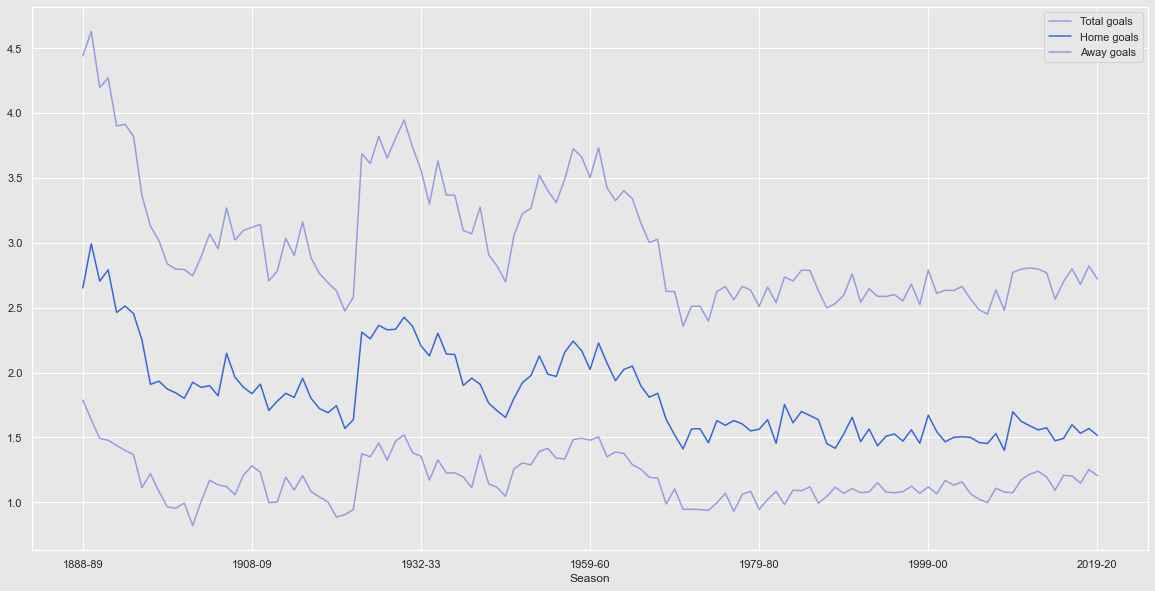

In [544]:
df = FootballData('1888-89', '2019-20').create_df()
df = df.groupby(['Season']).agg({'Total goals': 'mean', 'Home goals': 'mean', 'Away goals': 'mean'}).plot.line(figsize=(20,10))

We saw that since 1888, the average number of goals scored per game in the top flight of English football has decreased dramatically. From averaging 4.5 goals per game down to just under 3 goals per game in recent years. However, over the course of history we see that the trend is not linear, and that for about the first 75 years, goals per game is volatile. After, the number of goals begins to stabilise, and has gradually seen a subtle upwards trend over the past 50 or so years.

Let's represent this stability of goals scored over time in another way:

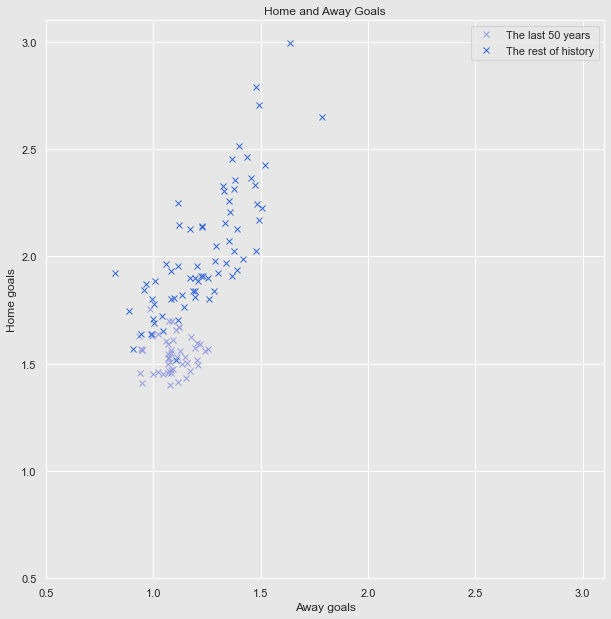

In [545]:
#Make a df starting from the inaugural season of the English Premier League
rest_of_history = FootballData('1888-89', '1969-70').create_df()
rest_of_history = rest_of_history.groupby(['Season'], as_index = False).agg({'Away goals': 'mean', 'Home goals': 'mean'})

l50y = FootballData('1970-71', '2019-20').create_df()
l50y = l50y.groupby(['Season'], as_index = False).agg({'Away goals': 'mean', 'Home goals': 'mean'})

plt.figure(figsize=(10,20)).add_subplot().set_aspect('equal', adjustable = 'box')
plt.plot('Away goals', 'Home goals', data = l50y, linestyle = 'none', marker = 'x', label = "The last 50 years")
plt.plot('Away goals', 'Home goals', data = rest_of_history, linestyle = 'none', marker = 'x', label = "The rest of history")
plt.title('Home and Away Goals')
plt.xlim(0.5,3.1)
plt.ylim(0.5,3.1)
plt.xlabel('Away goals')
plt.ylabel('Home goals')
plt.legend()

The tight cluster of blue points representing each season over the last 50 years stands in contrast to the variance of home and away goals scored in the rest of the league's history. We can see clearly that the amount of goals scored has become much more consistent as time goes on.

Moreover, while away goals have always been relatively hard to come by, it is the number of home goals in the last 50 years that has been the big change compared to the rest of history. A number of environmental factors have likely had an impact - the logistics of travelling away has become less onerous as time goes on and players have become more professional and their quality has become more evenspread across the league. In the modern day, many of these teams are significantly populated with star players imported from other countries, and fanbases have also become internationalised. All factors that likely dampen the advantage of playing at home vs. away.

### Top vs. Bottom Teams

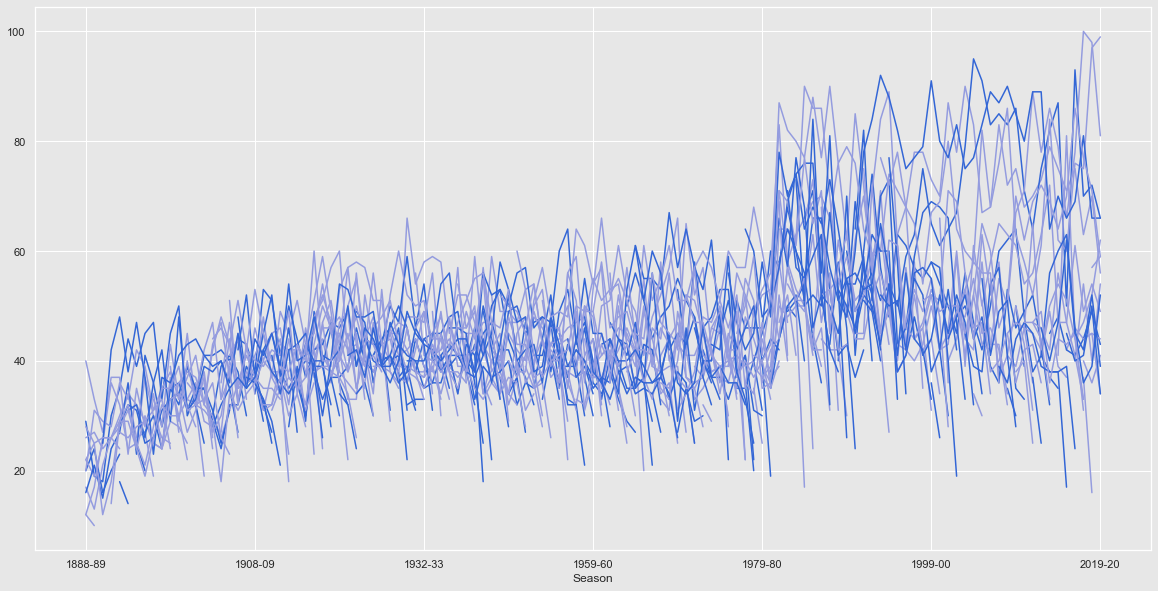

In [546]:
df = FootballData('1888-89', '2019-20').get_team_stats('all')
chart = df.groupby(['Season', 'Team'], as_index = False).agg({'Team goals': 'mean', 'Points': 'sum', 'Goal difference': 'sum'})
chart = chart.pivot_table(index = chart.Season, columns = ['Team'], values = ['Points']).plot(legend=False, figsize=(20,10))


### Top teams in history

When it comes to English football, the biggest giants of the league are generally well known: Manchester United, Liverpool, and Arsenal  are the three most prolific winners of the top division. In total, 24 clubs have won the top division in 122 seasons.

Over the years, 65 clubs have played at least one season in the top division. 20 of them of them have managed to play in half (61 seasons) or more of these seasons. This seems like a good place to start when considering the best teams in English football history. Admittedly, this will eliminate a number of big teams, including recent champions Leicester City, and other clubs with very respectable histories in the top flight such as Leeds United and Nottingham Forest, but the line has to be drawn somewhere. In a 122 season history, there will be casualties.

In [547]:
df = FootballData('1888-89', '2019-20').get_team_stats('all')
df = df.groupby(['Team'])['Season'].nunique().sort_values(ascending=False).head(20)
df

Team
Everton FC                    117
Aston Villa FC                106
Liverpool FC                  105
Arsenal FC                    103
Manchester United FC           95
Manchester City FC             91
Newcastle United FC            88
Sunderland AFC                 86
Chelsea FC                     85
Tottenham Hotspur FC           85
West Bromwich Albion FC        80
Bolton Wanderers FC            73
Blackburn Rovers FC            72
Sheffield Wednesday FC         66
Derby County FC                65
Wolverhampton Wanderers FC     65
Stoke City FC                  62
West Ham United FC             62
Sheffield United FC            61
Middlesbrough FC               61
Name: Season, dtype: int64

It makes sense to take into account not just how many seasons a club has in the top division, but how well they did while they were there. The obvious metric to use here is the amount of points each team earned during the season, since that is how the winner is determined. As above, we need to account for the fact that different seasons had different formats and the amount of points on offer was different. In this dataset, points are based on the modern standard (3 points for a win, 1 for a draw, 0 for a loss) for comparability across seasons.

For example, Everton's championship winning campaign in the 1890-91 season saw them finish with 29 points, although by the modern scoring they would have finished with 43. This would have seen them level with Crystal Palace in 14th place had they finished with the same total in 2019-20. This is unfair of course, because each team only played 22 games in 1890-91, giving them a maximum possible points total of 66. If we rebase this 43/66 figure to the 114 points total possible in 2019-20, we get an equivalent performance of 74 points. Still a relatively low total for a champion, but within the realms of possibility (Manchester United won the league in 1996-97 with 75 points). Therefore, instead of measuring the raw points totals, we will express each season performance as a percentage of the maximum possible points total for that season.

,Season,Team,Points,Teams,Fixtures,Total possible points,pct. of points
0,1888-89,Aston Villa FC,29,12,132,66.0,43.939394
1,1888-89,Blackburn Rovers FC,26,12,132,66.0,39.393939
2,1888-89,Bolton Wanderers FC,22,12,132,66.0,33.333333
3,1888-89,Derby County FC,16,12,132,66.0,24.242424
4,1888-89,Everton FC,20,12,132,66.0,30.303030
...,...,...,...,...,...,...,...
1617,2019-20,Aston Villa FC,35,20,380,114.0,30.701754
1616,2019-20,Arsenal FC,56,20,380,114.0,49.122807
1626,2019-20,West Ham United FC,39,20,380,114.0,34.210526
1620,2019-20,Liverpool FC,99,20,380,114.0,86.842105


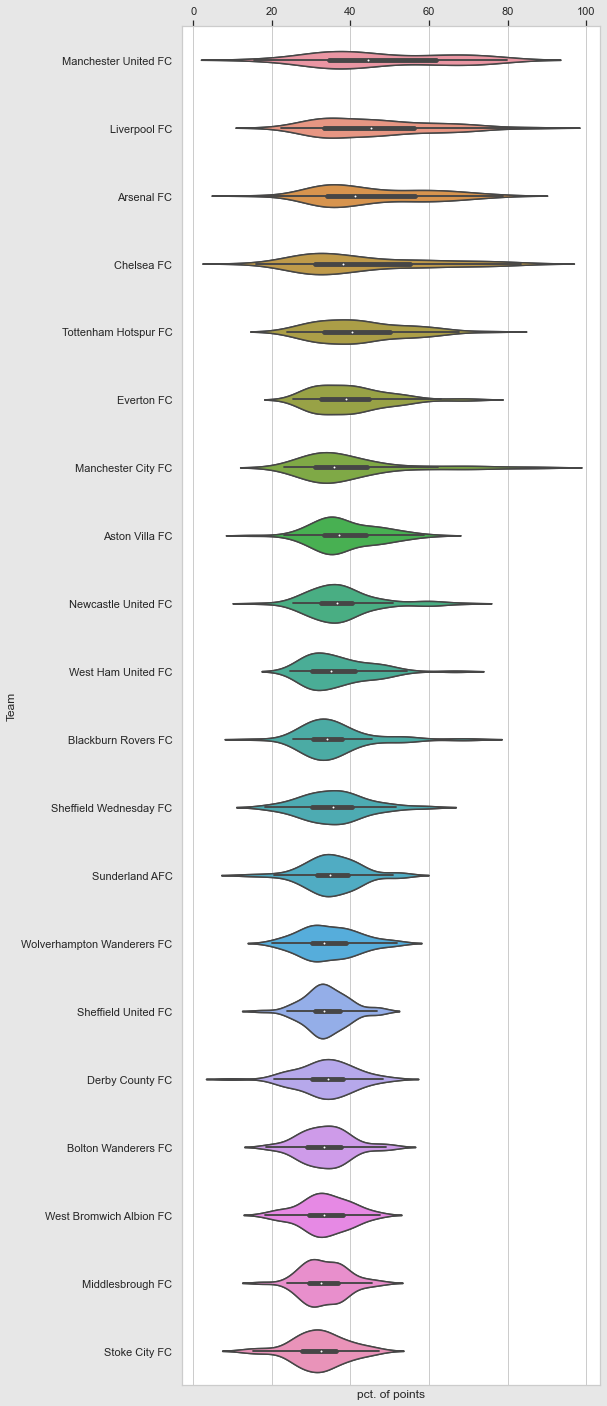

In [548]:
df = FootballData('1888-89', '2019-20').get_team_stats('all')
#Create a list of the top 20 teams by number of top division appearances from the filtered df
top_20_teams = df.groupby(['Team'])['Season'].nunique().sort_values(ascending=False)[:20]
teams = []
for team in top_20_teams.index:
    teams.append(team)
#Get the points totals for each of these 20 teams by season
df = FootballData('1888-89', '2019-20').get_team_stats(*teams)
points = df.groupby(['Season', 'Team'], as_index=False).agg({'Points': 'sum'})
#Get the maximum total points for each season based on the number of teams and fixtures
df = FootballData('1888-89', '2019-20').get_team_stats('all')
number_of_teams = df.groupby(['Season'])['Team'].nunique()
df = FootballData('1888-89', '2019-20').create_df()
number_of_games = df.groupby(['Season']).agg({'Date':'count'})
max_points = pd.merge(number_of_teams, number_of_games, on='Season').sort_values('Season', ascending=True)
max_points = max_points.rename(columns={'Date':'Fixtures', 'Team': 'Teams'})
max_points['Total possible points'] = max_points['Fixtures'] / max_points['Teams'] * 2 * 3
#Merge them and calculate the % of maximum possible points
chart = pd.merge(points, max_points, on='Season').sort_values('Season', ascending=True)
chart['pct. of points'] = chart['Points']/chart['Total possible points']*100
#Create an order object which ranks each team by their average points total
order = chart.groupby(['Team']).agg({'pct. of points': 'mean'}).sort_values(by='pct. of points', ascending=False).index
#Plot the data using a seaborn violinplot
plt.figure(figsize=(7.5,25))
sns.set_style('whitegrid')
sns.violinplot(y='Team', x='pct. of points', data = chart, order = order)
ax = sns.violinplot(y='Team', x='pct. of points', data = chart, order = order)
ax.xaxis.set_ticks_position('top')
chart

To visualise the historical performance of the top 20 teams, a violin plot has been used to show the distribution of season performances. The white dot represents the median performance for each team, with the thick bar representing the interquartile range on either side of the median. The extending lines mark a 95% confidence interval. Finally the thickness of the 'violin' itself represents the distribution of instances.

Note that the violin plot is ordered by the average % of maximum possible points rather than the median. It is arguable that ranking by median would be more appropriate to avoid overweighting outliers. However, in this case, I have chosen to rank them by average, because a reflection of a team's historical "greatness" the best and poorest performances should have more weight. In my book, a single championship win should be worth more than a few seasons of mid-table performances. 

Ranking these by average rather than median benefits teams like Chelsea, whose recent successes (with some enormous winning points totals over the last 20 years) have pulled them to 4th place, while ranking them by median would put them 12th. The shape of the violin tells us that for a majority of their top division history, their performance is closer to that of a team like West Ham or Middlesbrough, but unlike those two clubs, whose violins tail off very quickly past the 60% mark, Chelsea's extends well past the 80% mark, showing the impact of being a serious title-contender, including five title-winning performances since 2004.

Perhaps even more obviously, if we were to rank the teams by their median performance, Liverpool would finish below Arsenal. While both are historically great clubs, 19 titles (2nd) to Arsenal's 13 (3rd) is inarguable.

Since we also found there is a trend towards higher relative points totals for top teams compared to bottom teams now compared to 100 years ago, there is also a natural weighting towards seasons closer to the present. Again, I think this is justifiable - Sunderland AFC may have won the title 4 times (=6th with Manchester City and Chelsea) in their history, but the last time they did so was in the 1935-36 season. They are surely a big club in the scheme of things, but you'd be hard-pressed to argue that they are a historical giant in line with Chelsea and Manchester City. 

While this model of historical success does not explicitly take into account the number of titles actually won, it does weight towards consistently competitive runs to the title, especially in the last 75 years.

# C. The Sir Alex Ferguson Era

### Measuring success

With the most illustrious periods of domestic success in English football history, it's obvious that Ferguson's 27 years brought success to Manchester United. To visualise his impact, let's look at United's final positions in each of those 27 league seasons compared to its other finishes in the top flight before and after. 

To do this we need to add the finishing positions for United in each season, which is determined firstly by the number of points earned, and secondly by the goal difference if the number of points is the same.

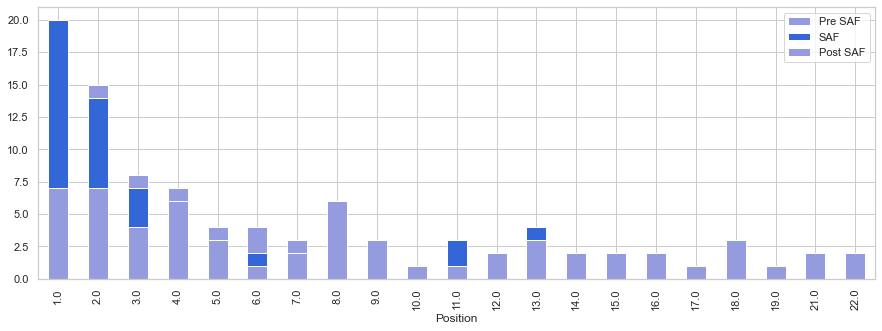

In [550]:
#To determine the finishing position of any team, we need a df with each team's results to rank
df = FootballData('1888-89', '2019-20').get_team_stats('all')

#Aggregate the points and goal difference of each team by season, and then sort these values by Season, then points, then goal difference in descending order
chart = df.groupby(['Season', 'Team'], as_index = False).agg({'Points': 'sum', 'Goal difference': 'sum'}).sort_values(ascending=False, by=['Season', 'Points', 'Goal difference'])
#Create a new column, 'Position' and populate it with the rank of each team. The rank is determined by the order of the df, so the .sort_values in the previous line is essential
chart['Position'] = chart.groupby('Season')['Points'].rank('first', ascending=False)
#Filter to just the Manchester United seasons, and sort this df in ascending order by season
filter = chart.loc[chart['Team'] == 'Manchester United FC'].sort_values(ascending=True, by=['Season']).reset_index(drop=True)
#Grab the index values for the first and last seasons Ferguson was in charge, and the current(latest) season
first_saf_season = filter[filter['Season'] == '1986-87'].index.values.astype(int)[0]
last_saf_season = filter[filter['Season'] == '2012-13'].index.values.astype(int)[0]
current_season = filter[filter['Season'] == '2019-20'].index.values.astype(int)[0]
#drop columns we don't need from the filter
filter = filter.drop(['Team', 'Points', 'Goal difference'], axis=1)
#add a helper column called 'position_count'
filter['Position_count'] = filter['Position']
#groupby each position and count the frequency each occurs
chart = filter.groupby(['Position']).agg({'Position_count':'count'})
#filter to the pre-Ferguson, Ferguson, and post-Ferguson seasons separately and do the same thing, adding each as a column to the chart df
pre_SAF = filter[:first_saf_season]
chart['Pre SAF'] = pre_SAF.groupby(['Position']).agg({'Position_count':'count'})
SAF = filter[first_saf_season:last_saf_season+1]
chart['SAF'] = SAF.groupby(['Position']).agg({'Position_count':'count'})
post_SAF = filter[last_saf_season+1:]
chart['Post SAF'] = post_SAF.groupby(['Position']).agg({'Position_count':'count'})
#remove the helper column
chart = chart.drop('Position_count', axis=1)
#Plot as a bar chart
chart.plot.bar(stacked=True, figsize=(15,5))

,Season,Top 5 upper,Top 5 lower,Top 5 avg,Bottom 5 upper,Bottom 5 lower,Bottom 5 avg,Teams,Fixtures,Total possible points,Points difference
0,1888-89,33.333333,60.606061,43.939394,18.181818,30.303030,23.333333,12,132,66.0,20.606061
1,1889-90,37.878788,50.000000,42.727273,15.151515,28.787879,23.636364,12,132,66.0,19.090909
2,1890-91,37.878788,43.939394,40.303030,18.181818,31.818182,24.848485,12,132,66.0,15.454545
3,1891-92,35.897436,53.846154,44.358974,14.102564,30.769231,22.307692,14,182,78.0,22.051282
4,1892-93,35.555556,53.333333,41.777778,20.000000,30.000000,26.444444,16,240,90.0,15.333333
...,...,...,...,...,...,...,...,...,...,...,...
116,2015-16,57.894737,71.052632,62.105263,14.912281,36.842105,29.649123,20,380,114.0,32.456140
117,2016-17,65.789474,81.578947,71.578947,21.052632,35.087719,29.122807,20,380,114.0,42.456140
118,2017-18,61.403509,87.719298,70.701754,27.192982,32.456140,29.824561,20,380,114.0,40.877193
119,2018-19,61.403509,85.964912,71.578947,14.035088,34.210526,26.491228,20,380,114.0,45.087719


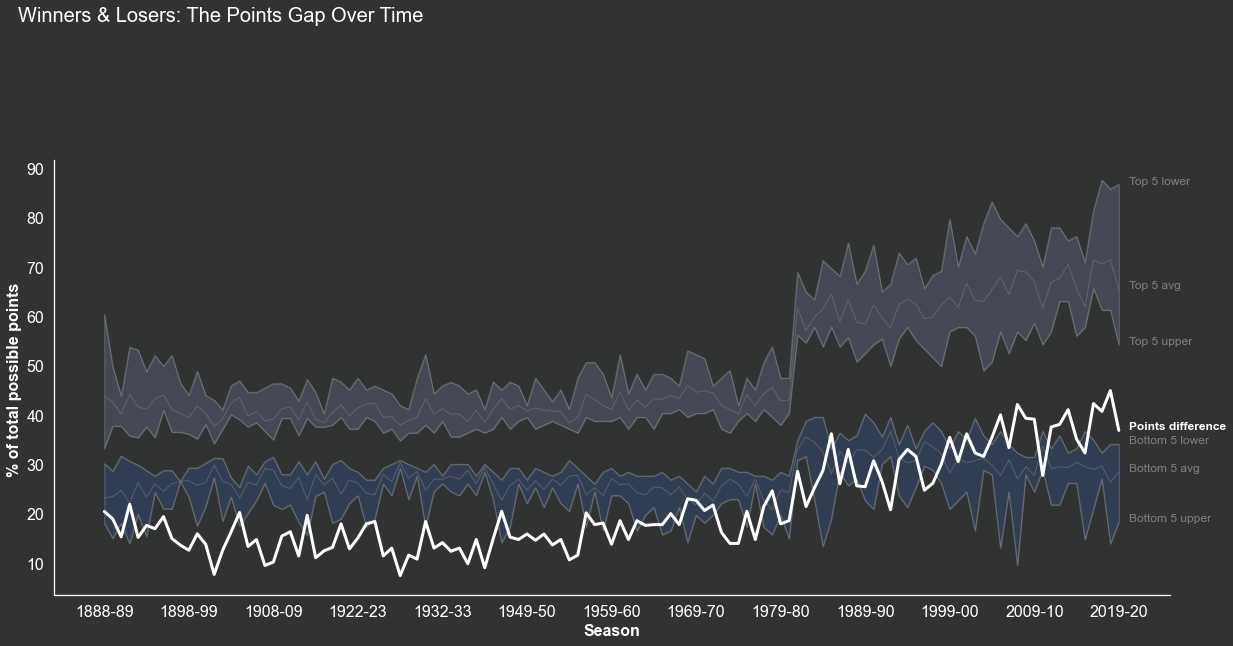

In [551]:
#The data
df = FootballData('1888-89', '2019-20').create_df()
number_of_games = df.groupby(['Season']).agg({'Date':'count'})

df = FootballData('1888-89', '2019-20').get_team_stats('all')
number_of_teams = df.groupby(['Season'])['Team'].nunique()
df = df.groupby(['Season', 'Team'], as_index=False).agg({'Points':'sum'})
top_5 = df.sort_values(['Points'], ascending=False).groupby('Season').head(5)
top_5 = top_5.sort_values('Season', ascending=False)
top_5_upper = top_5.sort_values(['Points']).groupby('Season').head(1)
top_5_upper = top_5_upper.sort_values('Season', ascending=True).drop(columns=['Team'])
top_5_lower = top_5.sort_values(['Points']).groupby('Season').tail(1)
top_5_lower = top_5_lower.sort_values('Season', ascending=True).drop(columns=['Team'])
top_5_avg = top_5.groupby(['Season'], as_index=False).agg({'Points':'mean'})
top_5 = pd.merge(top_5_upper, top_5_lower, on='Season')
top_5 = pd.merge(top_5, top_5_avg, on='Season')
top_5 = top_5.rename(columns={'Points_x':'Top 5 upper', 'Points_y':'Top 5 lower', 'Points':'Top 5 avg'})
bottom_5 = df.sort_values(['Points'], ascending=False).groupby('Season').tail(5)
bottom_5 = bottom_5.sort_values('Season', ascending=False)
bottom_5_upper = bottom_5.sort_values(['Points']).groupby('Season').head(1)
bottom_5_upper = bottom_5_upper.sort_values('Season', ascending=True).drop(columns=['Team'])
bottom_5_lower = bottom_5.sort_values(['Points']).groupby('Season').tail(1)
bottom_5_lower = bottom_5_lower.sort_values('Season', ascending=True).drop(columns=['Team'])
bottom_5_avg = bottom_5.groupby(['Season'], as_index=False).agg({'Points':'mean'})
bottom_5 = pd.merge(bottom_5_upper, bottom_5_lower, on='Season')
bottom_5 = pd.merge(bottom_5, bottom_5_avg, on='Season')
bottom_5 = bottom_5.rename(columns={'Points_x':'Bottom 5 upper', 'Points_y':'Bottom 5 lower', 'Points':'Bottom 5 avg'})
chart = pd.merge(top_5, bottom_5, on='Season')

total_possible_points = pd.merge(number_of_teams, number_of_games, on='Season').sort_values('Season', ascending=True)
total_possible_points = total_possible_points.rename(columns={'Date':'Fixtures', 'Team': 'Teams'})
total_possible_points['Total possible points'] = total_possible_points['Fixtures'] / total_possible_points['Teams'] * 2 * 3
total_possible_points['Total possible points'] = total_possible_points['Fixtures'] / total_possible_points['Teams'] * 2 * 3
chart = pd.merge(chart, total_possible_points, on='Season')

chart['Points difference'] = chart['Top 5 avg'] - chart['Bottom 5 avg']
chart['Points difference'] = chart['Points difference']/chart['Total possible points']*100
chart['Top 5 upper'] = chart['Top 5 upper']/chart['Total possible points']*100
chart['Top 5 lower'] = chart['Top 5 lower']/chart['Total possible points']*100
chart['Top 5 avg'] = chart['Top 5 avg']/chart['Total possible points']*100
chart['Bottom 5 upper'] = chart['Bottom 5 upper']/chart['Total possible points']*100
chart['Bottom 5 lower'] = chart['Bottom 5 lower']/chart['Total possible points']*100
chart['Bottom 5 avg'] = chart['Bottom 5 avg']/chart['Total possible points']*100

#The chart
background = '#313332'
text_colour = 'white'
filler = 'grey'
primary = 'white'

fig, ax = plt.subplots(figsize=(20,8))
fig.set_facecolor(background)
ax.patch.set_facecolor(background)
ax.grid(False)

spines = ["top","right","bottom","left"]
for s in spines:
    if s in ["top","right"]:
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_color(text_colour)

fig.text(0.1, 1.12, 'Winners & Losers: The Points Gap Over Time', fontsize=20, color=text_colour)

#A for loop which charts each specified df column in a list, and formats the last item in the list for emphasis
columns = ['Top 5 upper', 'Top 5 lower', 'Top 5 avg', 'Bottom 5 upper', 'Bottom 5 lower', 'Bottom 5 avg', 'Points difference']
for column in columns:
    x = chart['Season']
    y = chart[column]
    if column == columns[-1]:
        colour = primary
        alpha = 1
        linewidth = 3
        fontweight = 'bold'
    else:
        colour = filler
        alpha = 0.5
        linewidth = 1
        fontweight = 'normal'
    ax.plot(x, y, color=colour, alpha=alpha, linewidth=linewidth)
    coord = (chart['Season'].iloc[-1],chart[column].iloc[-1])
    ax.annotate(column, coord, textcoords='offset points', xytext=(10,0), ha='left', color=colour, fontweight=fontweight)

ax.fill_between(x, chart['Top 5 upper'], chart['Top 5 lower'], alpha=0.2)
ax.fill_between(x, chart['Bottom 5 upper'], chart['Bottom 5 lower'], alpha=0.2)

ax.set_xlabel('Season', fontweight='bold', fontsize=16, color=text_colour)
ax.set_ylabel('% of total possible points ', fontweight='bold', fontsize=16, color=text_colour)
ax.tick_params(axis='both', colors=text_colour, labelsize=16)
ax.set_xticks(range(0, len(chart['Season']), 10))
chart


Text(0, -60, 'Everton FC\n1914-15')

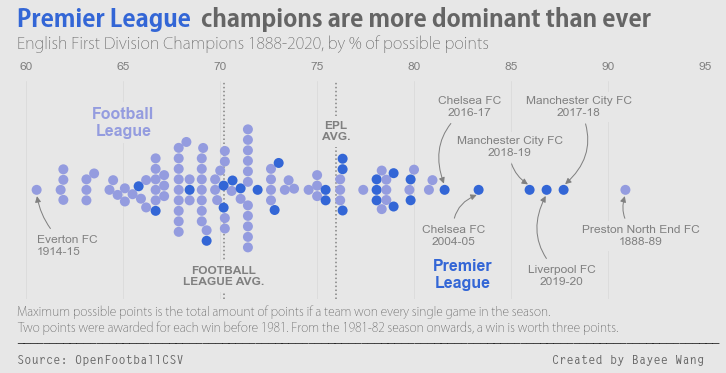

In [555]:
#The data
#Getting the number of games per season
df = FootballData('1888-89', '2019-20').create_df()
number_of_games = df.groupby(['Season']).agg({'Date':'count'})
#Getting the number of points per season by each team, and the number of teams participating in each season
df = FootballData('1888-89', '2019-20').get_team_stats('all')
points = df.groupby(['Season', 'Team'], as_index=False).agg({'Points':'sum'})
number_of_teams = points.groupby(['Season'])['Team'].nunique()
#Merge into a single df
data = pd.merge(points, number_of_games, on='Season')
data = pd.merge(data, number_of_teams, on='Season')
#Refine the df column names, and add calculated columns
data = data.rename(columns={'Team_x':'Team', 'Date':'Fixtures', 'Team_y':'Number of teams'})
points_for_win = []
for season in data['Season']:
    if season >= '1981-82':
        points_for_win.append(3)
    else:
        points_for_win.append(2)
data['Total possible points'] = data['Fixtures'] / data['Number of teams'] * 2 * points_for_win
data['Points pct'] = data['Points'] / data['Total possible points'] * 100
data['Position'] = data.groupby('Season')['Points'].rank('first', ascending=False)
data['Champions'] = data['Position'] == 1
data = data.sort_values(by='Team')
data = data[data['Champions'] == True].sort_values(by='Season')

era_list = []
for i in data['Season']:
    if i >= '1992-93':
        era = 'Premier League'
        era_list.append(era)
    elif i >= '1981-82':
        era = 'Football League'
        era_list.append(era)
    elif i >= '1945-46':
        era = 'Football League'
        era_list.append(era)
    else:
        era = 'Football League'
        era_list.append(era)
data['Era'] = era_list

#The chart
background = '#e7e7e7'
text_colour = '#232323'
secondary = 'grey'
primary = '#656565'
font = 'Kozuka Gothic Pro'
number_font = 'Letter Gothic Std'
#Set the figure aesthetics
sns.set(rc={'axes.facecolor':background, 'figure.facecolor':background, 'figure.figsize':(12.5,4)})
colours = ['#949cdf', '#3366d6']
sns.set_palette(sns.color_palette(colours))
fig, ax = plt.subplots()
#Plot the data using a seaborn catplot
sns.swarmplot(ax=ax, x=data['Points pct'], s=10, hue=data['Era'], y=['']*len(data), zorder=3)
ax.get_legend().remove()
#make adjustments
sns.despine(left=True, right=True, top=True, bottom=True)
ax.set_xlabel(None)
xtick_labels = list(range(60,100,5))
ax.set_xticks(xtick_labels)
ax.xaxis.set_label_position('top')
ax.grid(axis='x', color=secondary, alpha=0.1)
ax.tick_params(top=False, labeltop=True, labelbottom=False, labelsize=12, labelcolor='grey')

#Set the title
ax.text(59.5, -0.75, 'Premier League', fontsize=24, color='#3366d6', fontfamily=font, weight='bold')
ax.text(69, -0.75, 'champions are more dominant than ever', fontsize=24, color=primary, fontfamily=font, weight='bold')
ax.text(59.5, -0.65, 'English First Division Champions 1888-2020, by % of possible points', fontsize=16, color=primary, fontfamily=font, weight='normal')
#Data notes
ax.text(x=59.5, y=0.65, s='Maximum possible points is the total amount of points if a team won every single game in the season.\nTwo points were awarded for each win before 1981. From the 1981-82 season onwards, a win is worth three points.', color=text_colour, alpha=0.7, fontfamily=font)
#Set the source
ax.text(x=59.5, y=0.7, s='__________________________________________________________________________________________________________', color=text_colour)
ax.text(x=59.5, y=0.8, s='Source: OpenFootballCSV', color=primary, fontsize=12, ha='left', fontfamily=number_font, weight='bold')
ax.text(x=95, y=0.8, s='Created by Bayee Wang', color=primary, fontsize=12, ha='right', fontfamily=number_font, weight='bold')
#Annotations
#annotate the hues
ax.annotate(s='Premier\nLeague', xy=(82.5, 0.45),color='#3366d6', fontsize=16, backgroundcolor=background, zorder=2, ha='center', weight='bold')
ax.annotate(s='Football\nLeague', xy=(65, -0.25),color='#949cdf', fontsize=16, backgroundcolor=background, zorder=2, ha='center', weight='bold')
#annotate the EPL average
ax.annotate(s='EPL\nAVG.', xy=(data.loc[data['Season'] >= '1992-93']['Points pct'].mean(), 0), textcoords='offset points', xytext=(0,50),color=secondary, weight='bold', ha='center', backgroundcolor=background)
plt.axvline(x=data.loc[data['Season'] >= '1992-93']['Points pct'].mean(), linestyle='dotted', color=secondary, zorder=2)
#annotate the Football League average
ax.annotate(s='FOOTBALL\nLEAGUE AVG.', xy=(data.loc[data['Season'] <= '1992-93']['Points pct'].mean(), 0), textcoords='offset points', xytext=(0,-95),color=secondary, weight='bold', ha='center', backgroundcolor=background, zorder=2)
plt.axvline(x=data.loc[data['Season'] <= '1992-93']['Points pct'].mean(), linestyle='dotted', color=secondary, zorder=2)
#annotate the key teams
top = data.nlargest(6, 'Points pct')
bottom = data.nsmallest(1, 'Points pct')
#annotate the team with the highest points pct total
label = top['Team'].iloc[0] +'\n' + top['Season'].iloc[0]
ax.annotate(s=label, xy=(top['Points pct'].iloc[0], 0.02), textcoords='offset points', xytext=(15,-50),color=secondary, backgroundcolor=background, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=-0.4', 'color':secondary}, zorder=2, ha='center')
#annotate the team with the second highest points pct won
label = top['Team'].iloc[1] +'\n' + top['Season'].iloc[1]
ax.annotate(s=label, xy=(top['Points pct'].iloc[1], -0.02), textcoords='offset points', xytext=(15,70),color=secondary, backgroundcolor=background, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=-0.4', 'color':secondary}, zorder=2, ha='center')
#annotate the team with the third highest points pct won
label = top['Team'].iloc[2] +'\n' + top['Season'].iloc[2]
ax.annotate(s=label, xy=(top['Points pct'].iloc[2], 0.02), textcoords='offset points', xytext=(15,-90),color=secondary, backgroundcolor=background, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=-0.4', 'color':secondary}, zorder=2, ha='center')
#annotate the team with the fourth highest points pct won
label = top['Team'].iloc[3] +'\n' + top['Season'].iloc[3]
ax.annotate(s=label, xy=(top['Points pct'].iloc[3], -0.02), textcoords='offset points', xytext=(-20,30),color=secondary, backgroundcolor=background, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=0.3', 'color':secondary}, zorder=2, ha='center')
#annotate the team with the fifth highest points pct won
label = top['Team'].iloc[4] +'\n' + top['Season'].iloc[4]
ax.annotate(s=label, xy=(top['Points pct'].iloc[4], 0.02), textcoords='offset points', xytext=(-25,-50),color=secondary, backgroundcolor=background, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=-0.4', 'color':secondary}, zorder=2, ha='center')
#annotate the team with the sixth highest points pct won
label = top['Team'].iloc[5] +'\n' + top['Season'].iloc[5]
ax.annotate(s=label, xy=(top['Points pct'].iloc[5], -0.02), textcoords='offset points', xytext=(25,70),color=secondary, backgroundcolor=background, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=0.4', 'color':secondary}, zorder=2, ha='center')
#annotate the team with the lowest points pct won
label = data.loc[data['Points pct'].idxmin()]['Team'] +'\n' + data.loc[data['Points pct'].idxmin()]['Season']
ax.annotate(s=label, xy=(data.loc[data['Points pct'].idxmin()]['Points pct'], 0.02), textcoords='offset points', xytext=(0,-60),color=secondary, backgroundcolor=background, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=-0.2', 'color':secondary}, zorder=2, ha='left')

#plt.savefig('Champions.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')


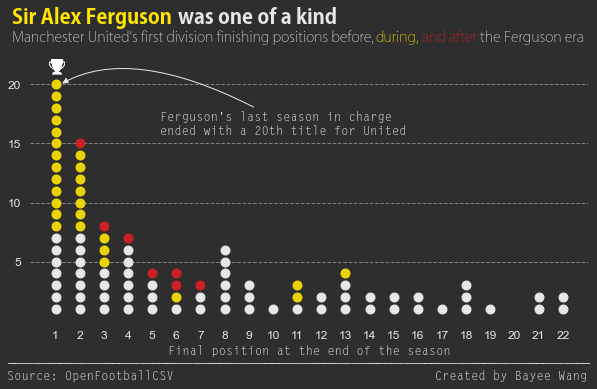

In [556]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import svgutils.compose as sc
from svgutils.compose import SVG

#To determine the finishing position of any team, we need a df with each team's results to rank
df = FootballData('1888-89', '2019-20').get_team_stats('all')
#Aggregate the points and goal difference of each team by season, and then sort these values by Season, then points, then goal difference in descending order
chart = df.groupby(['Season', 'Team'], as_index = False).agg({'Points': 'sum', 'Goal difference': 'sum'}).sort_values(ascending=False, by=['Season', 'Points', 'Goal difference'])
#Create a new column, 'Position' and populate it with the rank of each team. The rank is determined by the order of the df, so the .sort_values in the previous line is essential
chart['Position'] = chart.groupby('Season')['Points'].rank('first', ascending=False)
#Filter to just the Manchester United seasons, and sort this df in ascending order by season
filter = chart.loc[chart['Team'] == 'Manchester United FC'].sort_values(ascending=True, by=['Season']).reset_index(drop=True)
#Grab the index values for the first and last seasons Ferguson was in charge, and the current(latest) season
first_saf_season = filter[filter['Season'] == '1986-87'].index.values.astype(int)[0]
last_saf_season = filter[filter['Season'] == '2012-13'].index.values.astype(int)[0]
current_season = filter[filter['Season'] == '2019-20'].index.values.astype(int)[0]

#Establish the x and y coordinates for the scatterplot - x will be the season's finishing position from the 'Position' column, and y will be the number of times the position has been attained at each iteration in the for loop. This will ensure the points stack on top of each other
x = [] 
y = []
for position in filter['Position']:
    x.append(position)
    y.append(x.count(position))

#The chart
background = '#2e2e2e'
text_colour = '#e7e7e7'
filler = '#e7e7e7'
primary = '#ffe500'
secondary = '#db1f23'
font = 'Kozuka Gothic Pro'
number_font = 'Letter Gothic Std'
#Set figure aesthetics
fig, ax = plt.subplots(figsize=(10,5))
fig.set_facecolor(background)
ax.patch.set_facecolor(background)
ax.grid(False)
ax.grid(axis='y', alpha=0.4, linestyle='--')

spines = ["top","right","bottom","left"]
for s in spines:
    if s in ["top","right",'left','bottom']:
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_color(text_colour)

#Title text
fig.text(0.1, 0.95, 'Sir Alex Ferguson ', fontsize=20, color=primary, fontfamily=font, weight='bold')
fig.text(0.33, 0.95, 'was one of a kind', fontsize=20, color=text_colour, fontfamily=font, weight='bold')
fig.text(0.1, 0.9, 'Manchester United\'s first division finishing positions before,', fontsize=14, color=text_colour, fontfamily=font, weight='normal')
fig.text(0.605, 0.9, 'during,', fontsize=14, color=primary, fontfamily=font, weight='normal')
fig.text(0.665, 0.9, ' and after', fontsize=14, color=secondary, fontfamily=font, weight='normal')
fig.text(0.75, 0.9, 'the Ferguson era', fontsize=14, color=text_colour, fontfamily=font, weight='normal')
fig.canvas.draw()

#The plot
ax.scatter(x[:first_saf_season], y[:first_saf_season], marker = 'o', label = 'Pre SAF era', color=filler, edgecolors=None, s=80)
ax.scatter(x[first_saf_season:last_saf_season+1], y[first_saf_season:last_saf_season+1], marker = 'o', label = 'SAF era', color=primary, edgecolors=None, s=80, alpha=0.9)
ax.scatter(x[last_saf_season+1:], y[last_saf_season+1:], marker = 'o', label = 'Post SAF era', color=secondary, edgecolors=None, s=80, alpha=0.9)

#Post adjustments
ax.set_ylim(0,23)
ax.set_xlabel('Final position at the end of the season', weight='normal', fontsize=12, color=text_colour, fontfamily=number_font)
ax.tick_params(axis='both', colors=text_colour, labelsize=12)
ax.set_xticks(range(1,23,1))
ax.set_yticks(range(5,21,5))
ax.annotate(s='Ferguson\'s last season in charge\nended with a 20th title for United', xy=(1.2,20), textcoords='offset points', xytext=(100,-50),color=text_colour, fontfamily=number_font, fontsize=12, ha='left', arrowprops={'arrowstyle':'-|>', 'connectionstyle':'angle3,angleA=-30,angleB=30', 'color':text_colour})
#ax.annotate(s='Relegation Zone', xy=((17+23)*.5,4), ha='center', va='bottom', color=text_colour, fontfamily=number_font, textcoords='offset points', xytext=(0,20), arrowprops={'arrowstyle':'-[, widthB=5.0, lengthB=1.1'})

ax.text(x=-1, y=-3.5, s='________________________________________________________________________________________', color=text_colour)
ax.text(x=-1, y=-5, s='Source: OpenFootballCSV', color=text_colour, fontsize=12, ha='left', fontfamily=number_font)
ax.text(x=23, y=-5, s='Created by Bayee Wang', color=text_colour, fontsize=12, ha='right', fontfamily=number_font)

#Add trophy icon for first place
trophy_icon = plt.imread('trophy.png')
ax.add_artist(AnnotationBbox(OffsetImage(trophy_icon, zoom=0.35), (1.05,21.5), frameon=False))

#plt.savefig('SAF_1.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')

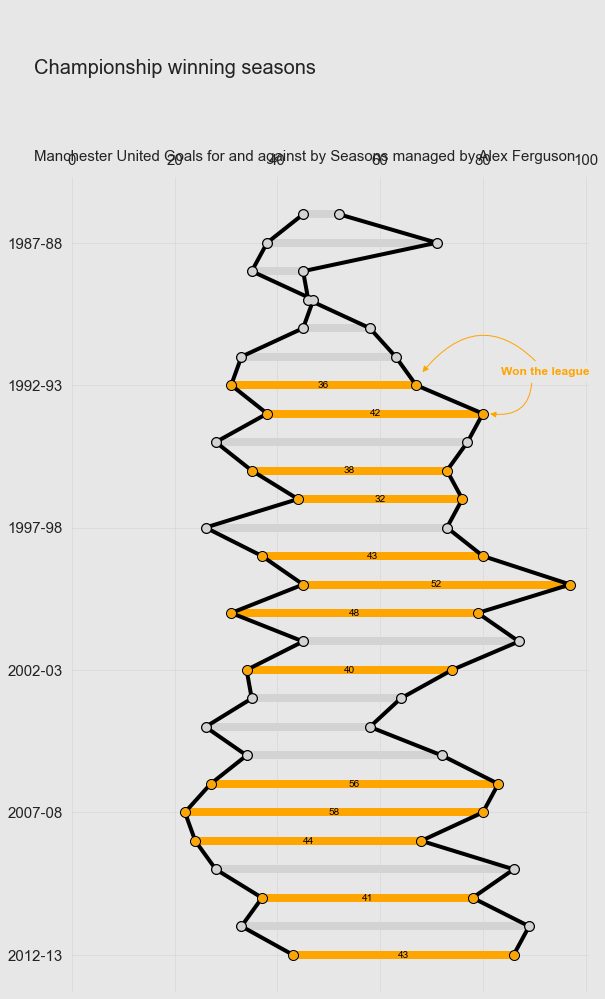

In [560]:
#The Data
df = FootballData('1986-87', '2012-13').get_team_stats('all')[13:]
data = df.groupby(['Season', 'Team'], as_index = False).agg({'Team goals': 'sum', 'Goals against': 'sum', 'Points': 'sum', 'Goal difference': 'sum'}).sort_values(ascending=False, by=['Season', 'Points', 'Goal difference'])
data['Position'] = data.groupby('Season')['Points'].rank('first', ascending=False)
data['Points diff'] = data['Team goals'] - data['Goals against']
chart = data.loc[data['Team'] == 'Manchester United FC']
champions = chart.loc[chart['Position'] == 1.0, ['Season', 'Team goals', 'Goals against', 'Points', 'Goal difference', 'Position', 'Points diff']]

#The Chart
background = '#e7e7e7'
text_colour = '#232323'
secondary = 'black'
primary = '#FFA500'
font = 'Kozuka Gothic Pro'
number_font = 'Letter Gothic Std'
filler = 'lightgrey'

fig, ax = plt.subplots(figsize=(8,12))
fig.set_facecolor(background)
fig.tight_layout()
ax.patch.set_facecolor(background)
ax.grid(alpha=0.5, ls='-', color=filler)

spines = ["top","right","bottom","left"]
for s in spines:
    if s in ["bottom", "top", "right", 'left']:
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_color(text_colour)

fig.text(0, 1.1, 'Championship winning seasons', fontsize=20, color=text_colour)
fig.text(0, 1, 'Manchester United Goals for and against by Seasons managed by Alex Ferguson', fontsize=15, color=text_colour)
x = chart['Team goals']
x1 = champions['Team goals']
y = chart['Season']
y1 = champions['Season']
ax.plot(x, y, color='black', marker = 'o', markersize = 10, markeredgecolor='black', lw=4,alpha = 1, zorder=2)
ax.scatter(x, y, color=filler, marker = 'o', lw=2.5, alpha=1, zorder=3)
ax.scatter(x1, y1, color=primary, marker = 'o', lw=2.5, alpha=1, zorder=3)
x = chart['Goals against']
x1 = champions['Goals against']
ax.plot(x, y, color='black', marker='o', markersize = 10, markeredgecolor='black', lw=4, alpha = 1, zorder=2)
ax.scatter(x, y, color=filler, marker = 'o', lw=2.5, alpha=1, zorder=3)
ax.scatter(x1, y1, color=primary, marker = 'o', lw=2.5, alpha=1, zorder=3)

#Connect the dots, make the championship winning seasons red
ax.hlines(y=chart['Season'], xmin=chart['Goals against'], xmax=chart['Team goals'], color=filler, alpha=1, zorder=2, lw=8)
ax.hlines(y=champions['Season'], xmin=champions['Goals against'], xmax=champions['Team goals'], color=primary, alpha=1, zorder=2, lw=8)

ax.xaxis.tick_top()
plt.yticks(range(0,30,5))
plt.xticks(range(0,120,20))
ax.tick_params(axis='both', colors=text_colour, labelsize=15, top=False, labeltop=True, labelbottom=False)

#Annotations and in-chart labels
for ts, xs, ys in zip(champions['Goals against'], champions['Points diff'], champions['Season']):
    label = '{:.0f}'.format(xs)
    ax.annotate(label, (ts + xs/2, ys), textcoords='offset points', xytext=(0,0), fontsize=10, ha='center', va='center', color='black')
ax.annotate('Goals For', (2.4,33), ha='right', color='white')
ax.annotate('Goals Against', (0.2,33), ha='left', color='white')
an1 = ax.annotate(s='Won the league', xy=(68,20.4), textcoords='offset points', xytext=(80,-1), ha='left', color=primary, fontweight='bold', backgroundcolor=background, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=0.6', 'color':primary})
an2 = ax.annotate(s='Won the league', xy=(81,19), textcoords=an1, xytext=(0.4,0), ha='left', alpha=0.0, arrowprops={'arrowstyle':'-|>', 'connectionstyle':'arc3,rad=-0.6', 'color':primary})

#plt.savefig('GF_A.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')

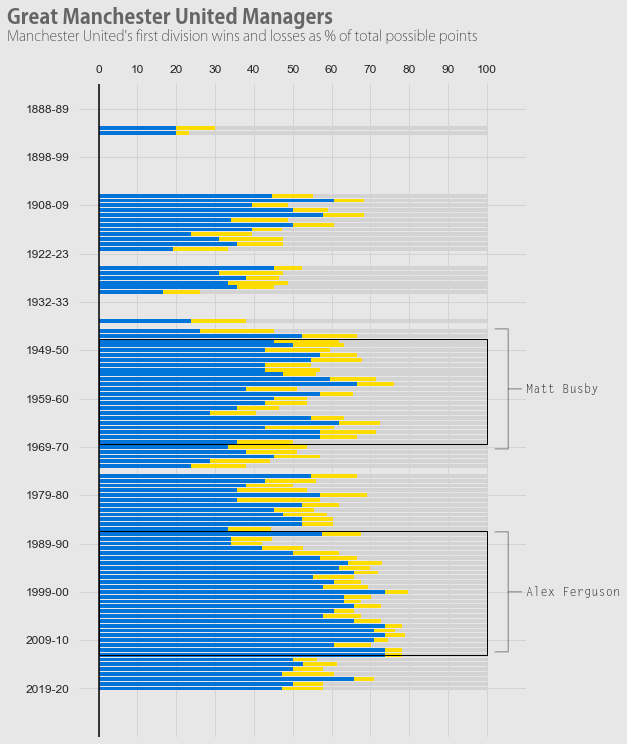

In [558]:
#The Data
#Getting the number of games per season
df = FootballData('1892-93', '2019-20').create_df()
number_of_games = df.groupby(['Season']).agg({'Date':'count'})

df = FootballData('1888-89', '2019-20').get_team_stats('all')
df['Win'] = df['Result'].apply(lambda x: x == 'Win')
df['Win'] = df['Win'] * df['Points']
df['Draw'] = df['Result'].apply(lambda x: x == 'Draw')

result_breakdown = df.groupby(['Season', 'Team'], as_index = False).agg({'Win': 'sum', 'Draw': 'sum', 'Points': 'sum'})
number_of_teams = df.groupby(['Season'])['Team'].nunique()

#Merge into a single df
data = pd.merge(result_breakdown, number_of_games, on='Season')
data = pd.merge(data, number_of_teams, on='Season')
#Refine the df column names, and add calculated columns
data = data.rename(columns={'Team_x':'Team', 'Date':'Fixtures', 'Team_y':'Number of teams'})
points_for_win = []
for season in data['Season']:
    if season >= '1981-82':
        points_for_win.append(3)
    else:
        points_for_win.append(2)
data['Total possible points'] = data['Fixtures'] / data['Number of teams'] * 2 * points_for_win
data['Win pct'] = data['Win'] / data['Total possible points'] * 100
data['Draw pct'] = data['Draw'] / data['Total possible points'] * 100
data['Points pct'] = data['Points'] / data['Total possible points'] * 100
data['Position'] = data.groupby('Season')['Points'].rank('first', ascending=False)
data['Champions'] = data['Position'] == 1
data = data[data['Team'] == 'Manchester United FC'].sort_values(by='Season')

games = df.groupby(['Season'], as_index=False).agg({'Date':'count'})
data = pd.merge(games, data, on='Season', how='outer')
data = data.fillna(0)

#The Chart
background = '#e7e7e7'
text_colour = '#232323'
secondary = 'grey'
primary = '#656565'
blue = '#0074D9'
yellow = '#FFDC00'
font = 'Kozuka Gothic Pro'
number_font = 'Letter Gothic Std'

fig, ax = plt.subplots(figsize=(8,12))
fig.set_facecolor(background)
ax.patch.set_facecolor(background)
ax.grid(axis='x', alpha=1, linestyle='-', color='lightgrey', zorder=500)
ax.grid(axis='y', alpha=1, linestyle='-', color='lightgrey', zorder=1)

plt.xticks(range(0,101,10), color='black', zorder=500)
plt.yticks(range(0,128,10), color='black', zorder=1)
plt.axvline(x=0, linestyle='-', color='black', zorder=500)

ax.tick_params(axis='both', colors=text_colour, labelsize=12, top=False, labeltop=True, labelbottom=False, zorder=1)

spines = ["top","right","bottom","left"]
for s in spines:
    if s in ["bottom", "top", "right", 'left']:
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_color(text_colour)

#Title text
fig.text(0, 0.95, 'Great Manchester United Managers', fontsize=20, color=primary, fontfamily=font, weight='bold')
fig.text(0, 0.93, 'Manchester United\'s first division wins and losses as % of total possible points', fontsize=14, color=text_colour, fontfamily=font, weight='normal')


#The plot
x = data['Season']
y1 = data['Win pct']
y2 = data['Draw pct']
y3 = (data['Total possible points'] - data['Points'])/data['Total possible points'] * 100

plt.xlim(-5, 110)
plt.ylim(-5, 130)
plt.gca().invert_yaxis()

ax.barh(x, y1, color=blue, edgecolor='none', zorder=50)
ax.barh(x, y2, left=y1, color=yellow, edgecolor='none', zorder=50)
ax.barh(x, y3, left=y1+y2, color='lightgrey', edgecolor='none', zorder=50)

first_busby_season = data[data['Season'] == '1946-47'].index.values.astype(int)[0]
busby_season = data[data['Season'] == '1957-58'].index.values.astype(int)[0]
last_busby_season = data[data['Season'] == '1968-69'].index.values.astype(int)[0]

ax.annotate(s='Matt Busby', xy=(105,busby_season), ha='left', va='center', color=text_colour, fontfamily=number_font, textcoords='offset points', xytext=(20,0), arrowprops={'color':'grey', 'arrowstyle':'-[, widthB=5, lengthB=1.1'})
plt.axvspan(0, 100, ymin=((1-(first_busby_season+1+5)/136)), ymax=(1-(last_busby_season+1+5)/136), facecolor='None', alpha=1, edgecolor='black', zorder=500)

first_saf_season = data[data['Season'] == '1986-87'].index.values.astype(int)[0]
saf_season = data[data['Season'] == '1999-00'].index.values.astype(int)[0]
last_saf_season = data[data['Season'] == '2012-13'].index.values.astype(int)[0]

ax.annotate(s='Alex Ferguson', xy=(105,saf_season), ha='left', va='center', color=text_colour, fontfamily=number_font, textcoords='offset points', xytext=(20,0), arrowprops={'color':'grey', 'arrowstyle':'-[, widthB=5, lengthB=1.1'})
plt.axvspan(0, 100, ymin=((1-(first_saf_season+1+5)/136)), ymax=(1-(last_saf_season+1+5)/136), facecolor='None', alpha=1, edgecolor='black', zorder=500)

